<h1><center>DSA 4212: Year 2019-2020</center></h1>
<h3><center> Assignment 2 (Deadline: 1st of May 2020 at 23:59) </center></h3>
<h3><center> To Be submitted on the lumiNUS </center></h3>
<h2><center> Group Number: ???? </center></h2>
<h2><center> Filename: assignment_2_XX.ipynb where XXX is your group number</center></h2>
<h2><center> Group Member 1: Student Name, Student ID </center></h2>
<h2><center> Group Member 2: Student Name, Student ID </center></h2>
<h2><center> Group Member 3: Student Name, Student ID </center></h2>



In [0]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import scipy
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import io

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Exercise 4: Book recommendations


The files `books.csv` and `ratings.csv` contain the description of $10000$ books and the ratings of $53424$ users. Build a book recommendation system out of this dataset.

**remark**: it may be a good idea to shuffle and split the data into a train/test subset.  
**remark**: think first about an appropriate metric to quantify how well your model is doing.  
**remark**: it may be a good idea to come-up first with one or two baseline/naive models.  



## 4.1 Import the Dataset




In [0]:
filename = "books_and_ratings.zip"
#shareable_link = "https://drive.google.com/open?id=1OJO7dITjEMBy7iAo0nrdK3Fi0Nlo21ju"
shareable_link = "https://drive.google.com/open?id=1W_fMbL9K-dAwV0OsFDk3yeb0RncBZJvQ"
temp_var, id = shareable_link.split("=")
downloaded = GoogleDrive(gauth).CreateFile({'id':id}) 
downloaded.GetContentFile(filename)

In [6]:
if ('books.csv' and 'ratings.csv') not in os.listdir('/content'):
  !unzip 'books_and_ratings.zip'

Archive:  books_and_ratings.zip
  inflating: books.csv               
  inflating: ratings.csv             


In [7]:
os.getcwd()

'/content'

In [8]:
os.listdir('/content')

['.config',
 'books.csv',
 'books_and_ratings.zip',
 'drive',
 'ratings.csv',
 'adc.json',
 'sample_data']

In [0]:
books_full_path = '/content/' + 'books.csv'
ratings_full_path = '/content/' + 'ratings.csv'
books_df = pd.read_csv(books_full_path, encoding = 'ISO-8859-1',engine='python')
ratings_df = pd.read_csv(ratings_full_path)

## 4.2 Simple Data Exploration


In [10]:
books_df.head()

,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPrÌ©",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


In [11]:
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [12]:
books_df.shape

(10000, 3)

In [13]:
ratings_df.shape

(5976479, 3)

In [14]:
nb_of_books = len(books_df["book_id"])
nb_of_users = len(onp.unique(onp.array(ratings_df["user_id"])))
print("Number of books Nb:{} \t Number of Unique Users Nu:{}".format(nb_of_books, nb_of_users))

Number of books Nb:10000 	 Number of Unique Users Nu:53424


In `books_df`, there are 10000 books. In the `ratings_df`, there are 5976479 examples but 53424 different unique users.

Let's see if all the `book_id` exist in both the books and ratings dataframe.



In [15]:
series_of_book_ids_from_books_df = books_df['book_id'].sort_values(ascending=True)
series_of_book_ids_from_ratings_df = ratings_df['book_id'].sort_values(ascending=True).unique()
series_of_book_ids_from_ratings_df == series_of_book_ids_from_books_df
print(ratings_df['rating'].unique())

[5 4 3 2 1]


The `book_id` from 1 to 10000 exist in both `books_df` and `ratings_df`. We can conclude that, for everybook, there are at least one user who rated it.

The ratings are verified to be strictly 1 to 5.

## 4.3 Pre-processing

### 4.3.1 Train-Val-Test Split

We shall split the data into 80% for training set and 20% for test set. From the training set, we will further split 20% for the validation set.

**r_train_full**: The full training set before splitting into training and validation set.

**r_train**: The training set after splitting the full training set into training set and validation set.

**r_val**: The validation set

**r_test**: The test set

In [0]:
# Setting the seed
import random as random
random.seed(4212)

In [17]:
# We first shuffle the row numbers

row_index = onp.arange(len(ratings_df))
print(row_index)
onp.random.shuffle(row_index)
print(row_index)

[      0       1       2 ... 5976476 5976477 5976478]
[1969128 3489982 4974778 ... 1734468 4489247 4440434]


In [18]:
print(0.8 * 5976478) # Number of examples for the full training set
print(0.2 * 5976478) # Number of examples for test set

4781182.4
1195295.6


In [19]:
# Let's split the data into train and test accordingly
r_train_full = ratings_df.iloc[row_index[0:4781183]]
r_test = ratings_df.iloc[row_index[4781183:]]
print(r_train_full.shape)
print(r_test.shape)

(4781183, 3)
(1195296, 3)


In [20]:
print(0.8 * 4781183) # 80% of full training set for new training set
print(0.2 * 4781183) # 20% of full training set for validation set

3824946.4000000004
956236.6000000001


In [21]:
# Let's split the train set further into train set and validation set
# These will be used when cross-validation is necessary

r_train = r_train_full[0:3824947]
print(r_train.shape)

r_val = r_train_full[3824947:]
print(r_val.shape)

(3824947, 3)
(956236, 3)


In [22]:
display(r_train_full.head(2))
display(r_train.head(2))
display(r_val.head(2))
display(r_test.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


,user_id,book_id,rating
118805,3356,2303,3
5162883,48579,155,5


,user_id,book_id,rating
2791319,35501,597,5
1953709,26808,3792,3


## 4.4 Modelling



### 4.4.1 Naive Models

We will attempt 2 naive models, namely a user mean rating model and a book mean rating model.

The performance metric we will use for the naive models is Mean Square Error (MSE) that is the loss function 

$$
L(R) = \frac{1}{|J|} \sum_{(u,b)\in{J}} (\hat{R}_{u,b}^{(naive)} - R_{u,b})^2
$$ 

where 
- $\hat{R}_{u,b}^{(naive)}$ is the rating of user $u$ on book $b$ estimated by the naive model,
- $R_{u,b}$ is the actual rating of user u on book b and
- $J = ${$(u,b)$ such that user $u$ has rated book $b$}


#### Functions

In [0]:
def naive_loss(R_hat, R_actual):
  return np.mean((R_hat - R_actual)**2)

#### Mean User Rating

##### Pre-processing


In [24]:
mean_user_rating_df = r_train_full.copy()
display(mean_user_rating_df.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [0]:
# Create a new data frame with the mean ratings that each user give for the books they rated

mean_user_rating_df = mean_user_rating_df.groupby('user_id').mean().reset_index() # Obtain the mean rating for each user
mean_user_rating_df.drop('book_id',axis=1,inplace=True)

In [26]:
mean_user_rating_df.rename(columns = {"rating":"mean_user_rating"},inplace=True)
display(mean_user_rating_df.head(2))

,user_id,mean_user_rating
0,1,3.662921
1,2,4.450980


##### Test the Naive Mean User Rating Model

In [27]:
# Test the mean ratings model

testing_on_mean_user_rating_df = pd.merge(r_test,mean_user_rating_df)
display(testing_on_mean_user_rating_df.head(2))

,user_id,book_id,rating,mean_user_rating
0,35501,597,5,4.264151
1,35501,5052,5,4.264151


In [28]:
# Check if the dataframe contains any null values

testing_on_mean_user_rating_df.isna().values.any()

False

In [29]:
# Obtain the test MSE

mean_user_rating_test_mse = naive_loss(testing_on_mean_user_rating_df['mean_user_rating'],
                                       testing_on_mean_user_rating_df['rating'])
print("The test MSE is ",round(mean_user_rating_test_mse,3))

The test MSE is  0.8


#### Mean Book Rating

##### Pre-processing

In [30]:
mean_book_rating_df = r_train_full.copy()
display(mean_book_rating_df.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [0]:
# Create a new data frame with the mean ratings that each book received

mean_book_rating_df = mean_book_rating_df.groupby('book_id').mean().reset_index()
mean_book_rating_df.drop('user_id',axis=1,inplace=True)

In [32]:
mean_book_rating_df.rename(columns = {"rating":"mean_book_rating"},inplace=True)
display(mean_book_rating_df.head(2))

,book_id,mean_book_rating
0,1,4.282552
1,2,4.354979


In [33]:
# Test the mean ratings model

testing_on_mean_book_rating_df = pd.merge(r_test,mean_book_rating_df)
display(testing_on_mean_book_rating_df.head(2))

,user_id,book_id,rating,mean_book_rating
0,35501,597,5,3.775947
1,10241,597,4,3.775947


In [34]:
# Check if the dataframe contains any null values

testing_on_mean_book_rating_df.isna().values.any()

False

##### Test the Naive Mean Book Rating Model



In [35]:
# Obtain the test MSE

mean_book_rating_test_mse = naive_loss(testing_on_mean_book_rating_df['mean_book_rating'],
                                       testing_on_mean_book_rating_df['rating'])
print("The test MSE is ", round(mean_book_rating_test_mse,3))

The test MSE is  0.911


The above shows that the naive user mean rating model has a lower test MSE.

### 4.4.2 Combined Means of Naive Models

Now, we shall attempt to combine `mean_user_rating` and `mean_book_pairing` to see how well does the combined mean do. The approach is as follows:

1.   For each unique `user_id` and `book_id` pairing $(u,b)$, find the average of the `mean_user_rating` and the `mean_book_pairing`. This average will be referred to as `comb_mean_rating`. In other words, each $(u,b)$ pair has its own comb_mean_rating.
2.   Due to constraints, we can only predict the users' rating and the books' received rating in the test set separately.

  *   For each user $u$, we find the average of the mean rating of ($u$,$b$) pairings $\forall{b} \in$ books that $u$ has rated. This average will serve as the $\hat{R}_{u,b}$ for user $u$ in the test set.
  *   For each book $b$, we find the average of the mean rating of ($u$,$b$) pairings for all the ratings that book $b$ received from $u, \forall{u} \in$ users. This average will serve as the $\hat{R}_{u,b}$ that book $b$ received in the test set.





#### Pre-processing

In [36]:
comb_means_df = r_train_full.copy()
display(comb_means_df.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [37]:
# Merge in the column of mean user ratings of each user

comb_means_df2 = pd.merge(comb_means_df,mean_user_rating_df,on='user_id')
display(comb_means_df2.head(2))

,user_id,book_id,rating,mean_user_rating
0,26773,971,5,4.029703
1,26773,1026,4,4.029703


In [38]:
# Merge in the column of mean book ratings that each book received

comb_means_df3 = pd.merge(comb_means_df2,mean_book_rating_df,on='book_id')
display(comb_means_df3.head(2))

,user_id,book_id,rating,mean_user_rating,mean_book_rating
0,26773,971,5,4.029703,4.044794
1,34809,971,2,3.877358,4.044794


In [39]:
# Obtain the dataframe with the combined means column

mean_user_rating_series = comb_means_df3['mean_user_rating']
mean_book_rating_series = comb_means_df3['mean_book_rating']
comb_means_pretrain_df = comb_means_df3.assign(comb_mean_rating = pd.Series(
    (mean_user_rating_series + mean_book_rating_series)/2).values)
display(comb_means_pretrain_df.head(2))

,user_id,book_id,rating,mean_user_rating,mean_book_rating,comb_mean_rating
0,26773,971,5,4.029703,4.044794,4.037249
1,34809,971,2,3.877358,4.044794,3.961076


In [40]:
# Combine the user_id and book_id columns
# This will be the dataframe that the next few sections will base on
# It is the equivalent of r_train, except that `rating` is replaced by 
# `comb_mean_rating` which is the mean of `mean_user_rating` and `mean_book_rating`

comb_means_pretrain_df.drop(['rating','mean_user_rating','mean_book_rating'],axis=1,inplace=True)
display(comb_means_pretrain_df.head(2))

,user_id,book_id,comb_mean_rating
0,26773,971,4.037249
1,34809,971,3.961076


#### Combined Means for Users

In [41]:
comb_mean_user_rating_df = comb_means_pretrain_df.groupby('user_id').mean().reset_index() # Average combinned mean rating each user gave
comb_mean_user_rating_df.drop('book_id',axis=1,inplace=True)
display(comb_mean_user_rating_df.head(2))

,user_id,comb_mean_rating
0,1,3.788069
1,2,4.185824


##### Test the Combined Means Model in Predicting User Ratings


In [0]:
test_set = r_test.copy()

In [43]:
testing_on_comb_mean_user_rating_df = pd.merge(test_set,comb_mean_user_rating_df,on='user_id')
display(testing_on_comb_mean_user_rating_df.head())

,user_id,book_id,rating,comb_mean_rating
0,35501,597,5,4.099783
1,35501,5052,5,4.099783
2,35501,3127,5,4.099783
3,35501,9407,4,4.099783
4,35501,413,5,4.099783


In [44]:
# Obtain the test MSE
r_hat = testing_on_comb_mean_user_rating_df["comb_mean_rating"]
r_actual = testing_on_comb_mean_user_rating_df["rating"]
comb_user_test_mse = naive_loss(r_hat,r_actual)
print("The test MSE is ",comb_user_test_mse)

The test MSE is  0.8392796632308017


#### Combined Means for Books

In [45]:
comb_mean_book_rating_df = comb_means_pretrain_df.groupby('book_id').mean().reset_index() # Average combinned mean rating each book received
comb_mean_book_rating_df.drop('user_id',axis=1,inplace=True)
display(comb_mean_book_rating_df.head(2))

,book_id,comb_mean_rating
0,1,4.115085
1,2,4.156746


##### Test the Combined Means Model in Predicting Book Ratings


In [46]:
testing_on_comb_mean_book_rating_df = pd.merge(test_set,comb_mean_book_rating_df,on='book_id')
display(testing_on_comb_mean_book_rating_df.head())

,user_id,book_id,rating,comb_mean_rating
0,35501,597,5,3.837417
1,10241,597,4,3.837417
2,46841,597,3,3.837417
3,15547,597,2,3.837417
4,2149,597,3,3.837417


In [47]:
# Obtain the test MSE
r_hat = testing_on_comb_mean_book_rating_df["comb_mean_rating"]
r_actual = testing_on_comb_mean_book_rating_df["rating"]
comb_book_test_mse = naive_loss(r_hat,r_actual)
print("The test MSE is ",comb_book_test_mse)

The test MSE is  0.925705391079081


So far, the naive mean user rating still performs the best in terms of test MSE.

### 4.4.3 User Reversion Towards the Mean

We consider the regularized estimate

$$
\hat{R}_{u,b} = \frac{1}{\alpha + |F(u)|} (\alpha M + \sum_{f\in{F(u)}}R_{(u,b)})
$$

where 
- $M$ is the total mean of all the ratings 
- $F(u)$ is the set of films rated by user $u$, and $\alpha > 0$ is a parameter of the model.  

We shall choose $\alpha$ using cross-validation (CV), choosing the alpha that gives the lowest CV error. Our metric used will be the same as that used for the naive models.

#### Finding $|F(u)|$, $M$, and $\sum_{f\in{F(u)}}R_{(u,b)}$

In [48]:
display(r_train.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [49]:
# Finding |F(U)| of each user

rev_train_fu = r_train.groupby('user_id').size().reset_index(name = 'num_of_books_rated')
display(rev_train_fu.head(2))

,user_id,num_of_books_rated
0,1,72
1,2,44


In [50]:
# Finding M 

M = r_train['rating'].mean()
print(M)
# M is 3.919

3.9201011151265623


In [51]:
# Finding sum of R_ub

rev_train_sum_of_ratings = r_train.groupby('user_id').sum().reset_index()
rev_train_sum_of_ratings.drop('book_id',axis = 1,inplace=True)
rev_train_sum_of_ratings.rename(columns = {"rating" : "sum_of_ratings"}, inplace=True)
display(rev_train_sum_of_ratings.head(2))

,user_id,sum_of_ratings
0,1,266
1,2,200


For convenience, let's define some functions that helps us obtain the above values.

#### Functions

In [0]:
# Function that calculates r_hat
def rev_r_hat(alpha,mod_f,sum_of_R_ub,M):
  """
  Returns rating estimated by reversion towards mean
  """
  first_term = 1/ (alpha + mod_f)
  second_term = (alpha * M) + sum_of_R_ub
  return round(first_term * second_term)

In [0]:
# Functions for preprocessing

def get_fu(df):
  return df.groupby('user_id').size().reset_index(name = 'num_of_books_rated')

def get_M(df):
  return df['rating'].mean()

def get_sum_of_R_ub(df):
  rev_train_sum_of_ratings = df.groupby('user_id').sum().reset_index()
  rev_train_sum_of_ratings.drop('book_id',axis = 1,inplace=True)
  rev_train_sum_of_ratings.rename(columns = {"rating" : "sum_of_ratings"}, inplace=True)
  return rev_train_sum_of_ratings

def user_prepro_rev(rev_train):
  """
  Returns the training dataframe with desired headers and M
  ['user_id','book_id','rating',num_of_books_rated','sum_of_ratings']
  """

  # Obtain |F(u)|
  rev_train_fu = get_fu(rev_train)
  
  # Obtain M
  M = get_M(rev_train)

  # Obtain sum of R_ub
  rev_train_sum_of_ratings = get_sum_of_R_ub(rev_train)

  # Merge to obtain desired dataframe and M
  rev_train_temp = pd.merge(rev_train,rev_train_fu)
  rev_train_temp2 = pd.merge(rev_train_temp,rev_train_sum_of_ratings)
  rev_train_final = rev_train_temp2.groupby('user_id').mean().reset_index()
  return rev_train_final, M

In [0]:
# Helper merge function
def merge_df_on_user_id(df1,df2):
  merged_df = pd.merge(df1,df2,on='user_id')
  return merged_df

# Loss Function
def user_rev_loss(alpha,mod_f, sum_of_R_ub, train_df, df2, M):
  """
  Returns the MSE
  """
  # Merge the train set and validation set
  merged_df = merge_df_on_user_id(train_df,df2)
  return np.mean((merged_df['r_hat'] - merged_df['rating'])**2)

In [0]:
# Function for cross validation

def user_rev_cv(train_df,val_df,list_of_alphas, M):

  lowest_val_err = 1000
  best_alpha = 0
  val_err_hist = [] # Stores validation error

  mod_f = train_df['num_of_books_rated']
  sum_of_R_ub = train_df['sum_of_ratings']

  # Drop unnecessary columns to improve efficiency
  # train_precv only has user_id and r_hat
  train_precv = train_df.drop(['book_id','rating','num_of_books_rated','sum_of_ratings'],axis=1,inplace=False)

  for alpha in list_of_alphas:

    rev_train_cv = train_precv.assign(r_hat = pd.Series(rev_r_hat(alpha,mod_f,sum_of_R_ub,M).values)) # Adds a column of r_hat to train_precv
    
    # Find the validation error
    val_err = user_rev_loss(alpha,mod_f,sum_of_R_ub,rev_train_cv,val_df,M)
    print("Current alpha: ", alpha)
    print("Current CV Error: ", val_err)
    print("==============================")
    val_err_hist.append(val_err)
    if (lowest_val_err > val_err): # Records the alpha that gives the lowest val error
      lowest_val_err = val_err
      best_alpha = alpha
  return best_alpha, val_err_hist

In [0]:
# Functions for model testing

def test_user_model(train_df,test_df,best_alpha):
  """
  Returns the test MSE
  """
  mod_f = train_df['num_of_books_rated']
  sum_of_R_ub = train_df['sum_of_ratings']

  train_pretest = train_df.drop(['book_id','rating','num_of_books_rated','sum_of_ratings'],axis=1,inplace=False)

  rev_train_test = train_pretest.assign(r_hat = pd.Series(rev_r_hat(best_alpha,mod_f,sum_of_R_ub,M).values))

  test_err = user_rev_loss(best_alpha,mod_f,sum_of_R_ub,rev_train_test,test_df,M)

  return test_err

#### Pre-processing

In [0]:
rev_train = r_train.copy()

In [58]:
display(rev_train.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [59]:
# num_of_book_rated is our F(u), for user u
# sum_of_ratings is the sum of R_ub for user u and all the books u has rated

user_rev_train_precv, M = user_prepro_rev(rev_train)
print(M)
display(user_rev_train_precv.head(2))

3.9201011151265623


,user_id,book_id,rating,num_of_books_rated,sum_of_ratings
0,1,764.277778,3.694444,72.0,266.0
1,2,1907.750000,4.545455,44.0,200.0


#### Cross-Validation

In [0]:
rev_val = r_val.copy()

In [61]:
display(rev_val.head(2))

,user_id,book_id,rating
118805,3356,2303,3
5162883,48579,155,5


In [62]:
# Let's run cross-validation to find the best alpha to be used for testing

list_of_alphas = [0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10]

user_best_alpha, user_val_err_hist = user_rev_cv(user_rev_train_precv,rev_val,list_of_alphas,M)

Current alpha:  0.01
Current CV Error:  0.8813953877494677
Current alpha:  0.05
Current CV Error:  0.8813953877494677
Current alpha:  0.1
Current CV Error:  0.8813953877494677
Current alpha:  0.5
Current CV Error:  0.8813734266436319
Current alpha:  1
Current CV Error:  0.8811046645388795
Current alpha:  2
Current CV Error:  0.8808777331119096
Current alpha:  3
Current CV Error:  0.8808453143366282
Current alpha:  4
Current CV Error:  0.8808118497944022
Current alpha:  5
Current CV Error:  0.8807731564174535
Current alpha:  6
Current CV Error:  0.8810691084627644
Current alpha:  7
Current CV Error:  0.8813190467625147
Current alpha:  8
Current CV Error:  0.8818293810314608
Current alpha:  9
Current CV Error:  0.8823093880590147
Current alpha:  10
Current CV Error:  0.8828887429463019


Alpha chosen by CV:  5
Lowest CV Error:  0.8807731564174535


Text(0.5, 0, 'Alpha Values')

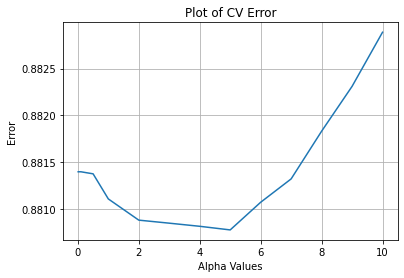

In [63]:
print("Alpha chosen by CV: ", user_best_alpha)
print("Lowest CV Error: ", min(user_val_err_hist))
plt.plot(list_of_alphas,user_val_err_hist)
plt.title("Plot of CV Error")
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Alpha Values")

#### Model Test

Now, let's test the model.

In [64]:
user_test_mse = test_user_model(user_rev_train_precv,r_test,user_best_alpha)
print("The test MSE obtained is ", user_test_mse)

The test MSE obtained is  0.8812996948036302


### 4.4.4 Book Reversion Towards the Mean

We will now repeat the same process to predict the rating a book will receive.

#### Functions

In [0]:
# Functions for preprocessing

def get_fb(df):
  return df.groupby('book_id').size().reset_index(name = 'num_of_users_rated')

def get_M(df):
  return df['rating'].mean()

def get_sum_of_R_bu(df):
  rev_train_sum_of_ratings = df.groupby('book_id').sum().reset_index()
  rev_train_sum_of_ratings.drop('user_id',axis = 1,inplace=True)
  rev_train_sum_of_ratings.rename(columns = {"rating" : "sum_of_ratings"}, inplace=True)
  return rev_train_sum_of_ratings

def prepro_book_rev(rev_train):
  """
  Returns the training dataframe with desired headers and M
  ['user_id','book_id','rating',num_of_books_rated','sum_of_ratings']
  """

  # Obtain |F(u)|
  rev_train_fb = get_fb(rev_train)
  
  # Obtain M
  M = get_M(rev_train)

  # Obtain sum of R_ub
  rev_train_sum_of_ratings = get_sum_of_R_bu(rev_train)

  # Merge to obtain desired dataframe and M
  rev_train_temp = pd.merge(rev_train,rev_train_fb)
  rev_train_temp2 = pd.merge(rev_train_temp,rev_train_sum_of_ratings)
  rev_train_final = rev_train_temp2.groupby('book_id').mean().reset_index()
  return rev_train_final, M

In [0]:
# Helper merge function
def merge_df_on_book_id(df1,df2):
  merged_df = pd.merge(df1,df2,on='book_id',)
  return merged_df

# Loss Function
def book_rev_loss(alpha,mod_f, sum_of_R_ub, train_df, df2, M):
  """
  Returns the MSE
  """
  # Merge the train set and validation set
  merged_df = merge_df_on_book_id(train_df,df2)
  return np.mean((merged_df['r_hat'] - merged_df['rating'])**2)

In [0]:
# Function for cross validation

def book_rev_cv(train_df,val_df,list_of_alphas, M):

  lowest_val_err = 1000
  best_alpha = 0
  val_err_hist = [] # Stores validation error

  mod_f = train_df['num_of_users_rated']
  sum_of_R_bu = train_df['sum_of_ratings']

  # Drop unnecessary columns to improve efficiency
  # train_precv only has book_id and r_hat
  train_precv = train_df.drop(['user_id','rating','num_of_users_rated','sum_of_ratings'],axis=1,inplace=False)

  for alpha in list_of_alphas:

    book_rev_train_cv = train_precv.assign(r_hat = pd.Series(rev_r_hat(alpha,mod_f,sum_of_R_bu,M).values)) # Adds a column of r_hat to train_precv

    # Find the validation error
    val_err = book_rev_loss(alpha,mod_f,sum_of_R_bu,book_rev_train_cv,val_df,M)
    print("Current alpha: ", alpha)
    print("Current CV Error: ", val_err)
    print("==============================")
    val_err_hist.append(val_err)
    if (lowest_val_err > val_err): # Records the alpha that gives the lowest val error
      lowest_val_err = val_err
      best_alpha = alpha
  return best_alpha, val_err_hist

In [0]:
# Functions for model testing

def test_book_model(train_df,test_df,best_alpha):
  """
  Returns the test MSE
  """
  mod_f = train_df['num_of_users_rated']
  sum_of_R_bu = train_df['sum_of_ratings']
  
  train_pretest = train_df.drop(['user_id','rating','num_of_users_rated','sum_of_ratings'],axis=1,inplace=False)

  rev_train_test = train_pretest.assign(r_hat = pd.Series(rev_r_hat(best_alpha,mod_f,sum_of_R_bu,M).values))

  test_err = book_rev_loss(best_alpha,mod_f,sum_of_R_bu,rev_train_test,test_df,M)

  return test_err

#### Pre-processing

In [69]:
display(rev_train.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [70]:
# num_of_users_rated is F(b), the number of ratings the book received
# sum_of_ratings is sum of R_bu, the sum of ratings that the book received from all users that rated it

book_rev_train_precv, M = prepro_book_rev(rev_train)
print(M)
display(book_rev_train_precv.head(2))

3.9201011151265623


,book_id,user_id,rating,num_of_users_rated,sum_of_ratings
0,1,27577.699741,4.281506,14664.0,62784.0
1,2,27716.348406,4.350699,13955.0,60714.0


#### Cross-Validation

In [71]:
display(rev_val.head(2))

,user_id,book_id,rating
118805,3356,2303,3
5162883,48579,155,5


In [72]:
# Let's run cross-validation to find the best alpha to be used for testing

list_of_alphas = [0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75]

book_best_alpha, book_val_err_hist = book_rev_cv(book_rev_train_precv,rev_val,list_of_alphas,M)

Current alpha:  0.01
Current CV Error:  0.9666588582734806
Current alpha:  0.05
Current CV Error:  0.9666588582734806
Current alpha:  0.1
Current CV Error:  0.9666588582734806
Current alpha:  0.5
Current CV Error:  0.9666588582734806
Current alpha:  1
Current CV Error:  0.9666285310320883
Current alpha:  2
Current CV Error:  0.9665793799856939
Current alpha:  3
Current CV Error:  0.9665689223162482
Current alpha:  4
Current CV Error:  0.9666034326254188
Current alpha:  5
Current CV Error:  0.9665312747062441
Current alpha:  6
Current CV Error:  0.9665145424351311
Current alpha:  7
Current CV Error:  0.9664988559309626
Current alpha:  8
Current CV Error:  0.9663869588678945
Current alpha:  9
Current CV Error:  0.966495718630129
Current alpha:  10
Current CV Error:  0.9663754554315044
Current alpha:  15
Current CV Error:  0.9663806842662271
Current alpha:  20
Current CV Error:  0.9666180733626427
Current alpha:  25
Current CV Error:  0.9666787278454273
Current alpha:  30
Current CV Error

Alpha chosen by CV:  10
Lowest CV Error:  0.9663754554315044


Text(0.5, 0, 'Alpha Values')

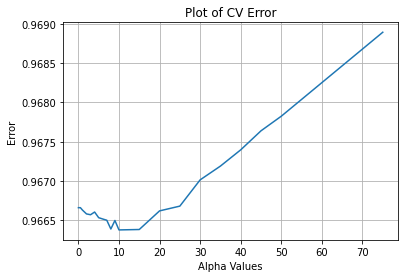

In [73]:
print("Alpha chosen by CV: ", book_best_alpha)
print("Lowest CV Error: ", min(book_val_err_hist))
plt.plot(list_of_alphas,book_val_err_hist)
plt.title("Plot of CV Error")
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Alpha Values")

#### Model Test

In [74]:
display(book_rev_train_precv.head(2))

,book_id,user_id,rating,num_of_users_rated,sum_of_ratings
0,1,27577.699741,4.281506,14664.0,62784.0
1,2,27716.348406,4.350699,13955.0,60714.0


In [75]:
book_test_mse = test_book_model(book_rev_train_precv,r_test,book_best_alpha)
print("The test MSE obtained is ", book_test_mse)

The test MSE obtained is  0.9670642250957086


In both reversion towards the mean models, we see that the user reversion towards the mean does better in terms of test MSE.

We shall now attempt the factor model.

### 4.4.5 Factor Model

From the few basic models above, we see that the naive mean user rating obtained the lowest test MSE. From here on, the naive mean user rating will serve as our $\hat{R}_{u,b}^{(naive)}$.

We would like to improve upon the basic naive mean user model. We define the residual
$$
r_{u,b} = R_{u,b} - \hat{R}_{u,b}^{(naive)}
$$

We want a model $\hat{r}_{u,b}$ that can approximate well the residuals $r_{u,b} \approx \hat{r}_{u,b}$ , so that
$$
R_{u,b} \approx \hat{R}_{u,b} = \hat{R}_{u,b}^{(naive)} + \hat{r}_{u,b}
$$
Therefore, we want to minimize the loss function
$$
L(\hat{r}_{u,b}) = \frac{1}{|J|} \sum_{(u,b)\in{J}} (r_{u,b} - \hat{r}_{u,b})^2
$$
$$
L(\{w_{u}\},\{w_{b}\}) = \frac{1}{|J|} \sum_{(u,b)\in{J}} (r_{u,b} - <w_{u},w_{b}>)^2
$$
where $ r_{u,b} \approx \hat{r}_{u,b} = <w_{u},w_{b}> $

The loss function is also our mean square error of the residuals.

#### Functions

In [0]:
#Loss Function
def fact_loss(df_arr,int_only_npy,r_ub,w_u,w_b):
  M = w_u@(w_b.T)
  r_hat = M[int_only_npy[:,0],int_only_npy[:,1]]
  return np.mean((r_ub - r_hat)**2)

grad_loss_u = jax.jit(jax.grad(fact_loss,argnums=3))
grad_loss_b = jax.jit(jax.grad(fact_loss,argnums=4))

In [0]:
# Alternate Minimization Functions

def minimize_U_fixed(npy_data,int_only_npy,npy_r_ub,U,B,LBFGS_iter):
  r,d = B.shape
  def grad_b_wrapper(B_flat):
    B = B_flat.reshape(r,d)
    return onp.array(grad_loss_b(npy_data,int_only_npy,npy_r_ub,U,B)).ravel()
  def loss_wrapper(B_flat):
    B=B_flat.reshape(r,d)
    return fact_loss(npy_data,int_only_npy,npy_r_ub,U,B)
  traj = scipy.optimize.minimize(fun = loss_wrapper,
                                 x0 = onp.array(B.ravel()),
                                 method="L-BFGS-B",
                                 jac=grad_b_wrapper,
                                 options={"maxiter":LBFGS_iter})
  B_final = traj["x"].reshape(r,d)
  return B_final

def minimize_B_fixed(npy_data,int_only_npy,npy_r_ub,U,B,LBFGS_iter):
  r,d = U.shape
  def grad_b_wrapper(U_flat):
    U=U_flat.reshape(r,d)
    return onp.array(grad_loss_u(npy_data,int_only_npy,npy_r_ub,U,B)).ravel()
  def loss_wrapper(U_flat):
    U = U_flat.reshape(r,d)
    return fact_loss(npy_data,int_only_npy,npy_r_ub,U,B)
  traj = scipy.optimize.minimize(fun=loss_wrapper,
                                 x0 = onp.array(U.ravel()),
                                 method='L-BFGS-B',
                                 jac=grad_b_wrapper,
                                 options={"maxiter":LBFGS_iter})
  U_final = traj["x"].reshape(r,d)
  return U_final    

#### Get the train set in numpy form with and finding $r_{u,b}$




In [124]:
fact_train = r_train.copy()
display(fact_train.head(2))

,user_id,book_id,rating
1969128,26773,971,5
3489982,8978,2769,4


In [125]:
# The mean_rating of each user is the R_hat_naive of each user
# This is obtained from the mean user rating

temp_fact_train = fact_train.groupby('user_id').mean().reset_index()
temp_fact_train2 = temp_fact_train.drop('book_id',axis=1)
temp_fact_train2.rename(columns = {"rating" : "mean_rating"},inplace=True)
display(temp_fact_train2.head(2))

,user_id,mean_rating
0,1,3.694444
1,2,4.545455


In [126]:
fact_train = pd.merge(fact_train,temp_fact_train2,on='user_id')
display(fact_train.head(2))

,user_id,book_id,rating,mean_rating
0,26773,971,5,4.061728
1,26773,1026,4,4.061728


In [127]:
# r_ub is the actual residual obtained from the difference between the actual rating and the mean_rating

actual_rating = fact_train['rating']
est_rating = fact_train['mean_rating']

fact_train = fact_train.assign(r_ub = pd.Series(actual_rating - est_rating).values)
fact_train.sort_values(by=['user_id','book_id'],inplace=True)
fact_train.astype({'user_id':'int64','book_id':'int64'})
display(fact_train.head())
print(fact_train.dtypes)

,user_id,book_id,rating,mean_rating,r_ub
671645,1,10,4,3.694444,0.305556
671628,1,11,5,3.694444,1.305556
671648,1,13,4,3.694444,0.305556
671615,1,22,3,3.694444,-0.694444
671654,1,31,4,3.694444,0.305556


user_id          int64
book_id          int64
rating           int64
mean_rating    float64
r_ub           float64
dtype: object


In [82]:
# convert the r_ub of each user into npy

train_r_ub = onp.array(fact_train['r_ub'])
print(train_r_ub)

[ 0.30555556  1.30555556  0.30555556 ... -0.32183908 -0.32183908
 -0.32183908]


In [83]:
# Convert the whole train set into npy

train_npy = onp.array(fact_train)
print(train_npy)

[[ 1.00000000e+00  1.00000000e+01  4.00000000e+00  3.69444444e+00
   3.05555556e-01]
 [ 1.00000000e+00  1.10000000e+01  5.00000000e+00  3.69444444e+00
   1.30555556e+00]
 [ 1.00000000e+00  1.30000000e+01  4.00000000e+00  3.69444444e+00
   3.05555556e-01]
 ...
 [ 5.34240000e+04  8.60900000e+03  4.00000000e+00  4.32183908e+00
  -3.21839080e-01]
 [ 5.34240000e+04  8.72600000e+03  4.00000000e+00  4.32183908e+00
  -3.21839080e-01]
 [ 5.34240000e+04  9.84900000e+03  4.00000000e+00  4.32183908e+00
  -3.21839080e-01]]


In [84]:
# Convert the integer columns ie user_id, book_id and rating into npy

train_int_npy = onp.array(fact_train[['user_id','book_id','rating']])
train_int_npy[:,0] = train_int_npy[:,0] - 1
train_int_npy[:,1] = train_int_npy[:,1] - 1
print(train_int_npy)

[[    0     9     4]
 [    0    10     5]
 [    0    12     4]
 ...
 [53423  8608     4]
 [53423  8725     4]
 [53423  9848     4]]


#### Get the validation set in npy form with and finding $r_{u,b}$

In [85]:
fact_val = r_val.copy()
display(fact_val.head(2))

,user_id,book_id,rating
118805,3356,2303,3
5162883,48579,155,5


In [86]:
# The mean_rating of each user is the R_hat_naive of each user
# This is obtained from the mean user rating

temp_fact_val = fact_val.groupby('user_id').mean().reset_index()
temp_fact_val2 = temp_fact_val.drop('book_id',axis=1)
temp_fact_val2.rename(columns = {"rating" : "mean_rating"},inplace=True)
display(temp_fact_val2.head(2))

,user_id,mean_rating
0,1,3.529412
1,2,3.857143


In [87]:
fact_val = pd.merge(fact_val,temp_fact_val2,on='user_id')
display(fact_val.head(2))

,user_id,book_id,rating,mean_rating
0,3356,2303,3,3.869565
1,3356,766,5,3.869565


In [0]:
actual_rating = fact_val['rating']
est_rating = fact_val['mean_rating']

In [89]:
# r_ub is the actual residual obtained from the difference between the actual rating and the mean_rating

fact_val = fact_val.assign(r_ub = pd.Series(actual_rating - est_rating).values)
fact_val.sort_values(by=['user_id','book_id'],inplace=True)
display(fact_val.head())

,user_id,book_id,rating,mean_rating,r_ub
292366,1,16,3,3.529412,-0.529412
292371,1,33,4,3.529412,0.470588
292362,1,60,3,3.529412,-0.529412
292361,1,66,4,3.529412,0.470588
292357,1,109,3,3.529412,-0.529412


In [90]:
# Convert the r_ub of each user into npy

val_r_ub = onp.array(fact_val['r_ub'])
print(val_r_ub)

[-0.52941176  0.47058824 -0.52941176 ... -0.52380952 -0.52380952
 -0.52380952]


In [91]:
# Convert the whole validation set into npy

val_npy = onp.array(fact_val)
print(val_npy)

[[ 1.00000000e+00  1.60000000e+01  3.00000000e+00  3.52941176e+00
  -5.29411765e-01]
 [ 1.00000000e+00  3.30000000e+01  4.00000000e+00  3.52941176e+00
   4.70588235e-01]
 [ 1.00000000e+00  6.00000000e+01  3.00000000e+00  3.52941176e+00
  -5.29411765e-01]
 ...
 [ 5.34240000e+04  4.00300000e+03  4.00000000e+00  4.52380952e+00
  -5.23809524e-01]
 [ 5.34240000e+04  4.19600000e+03  4.00000000e+00  4.52380952e+00
  -5.23809524e-01]
 [ 5.34240000e+04  4.27700000e+03  4.00000000e+00  4.52380952e+00
  -5.23809524e-01]]


In [92]:
# Convert the integer columns ie user_id, book_id and rating into npy

val_int_npy = onp.array(fact_val[['user_id','book_id','rating']])
val_int_npy[:,0] = val_int_npy[:,0] - 1
val_int_npy[:,1] = val_int_npy[:,1] - 1
print(val_int_npy)

[[    0    15     3]
 [    0    32     4]
 [    0    59     3]
 ...
 [53423  4002     4]
 [53423  4195     4]
 [53423  4276     4]]


#### Setting initial $w_{u},w_{b}$ for the train set with d=5

Recall that $ r_{u,b} \approx \hat{r}_{u,b} = <w_{u},w_{b}> $.

$w_{u}\in\mathbb{R}^{d}$ and $w_{b}\in\mathbb{R}^d$ are vectors of randomly generated weights that we will eventually train.

In [93]:
# Get wu for every user
d=5
num_of_users = len(fact_train['user_id'].unique())
w_u_init = onp.random.normal(0,2,size=(num_of_users,d))
print(w_u_init)
print(w_u_init.shape)

[[ 1.54661869 -0.47632017  1.13849038  0.43746517 -1.01489359]
 [ 0.85747014  0.77188076  0.2637507   1.44208283  1.66543176]
 [-2.08427522 -2.69336335 -0.93439361 -0.74592777  1.28460989]
 ...
 [-1.21142242  0.84377101  1.00229638  0.25470455 -1.32723293]
 [ 0.2796288   0.68408179  0.9746066  -2.50223964 -0.56587048]
 [-2.26549374  3.34304861 -1.91889491  0.56773183 -1.65024199]]
(53424, 5)


In [94]:
# Get wu for every user
d=5
num_of_books = len(fact_train['book_id'].unique())
w_b_init = onp.random.normal(0,2,size=(num_of_books,d))
print(w_b_init)
print(w_b_init.shape)

[[ 2.80892194 -4.36745526  0.75580265  2.27271946 -2.29982922]
 [-0.21118675 -2.45287236 -2.03296444  0.10239877  2.53032136]
 [ 2.7832747  -1.50749314 -2.84688895 -1.22571416  0.34526414]
 ...
 [ 0.12462481  3.09808981 -0.45653567  0.31260095 -2.14121616]
 [-0.65803186  1.48861955  1.75381814 -3.25835392  0.9847409 ]
 [-1.30629108 -0.51717885  0.59726047 -2.94901345  2.066702  ]]
(10000, 5)


#### Gradient Descent for d = 5 for Sanity Check

Note: The cells in this section are commented out for efficiency purposes.

In [0]:
# U = onp.copy(w_u_init)
# B = onp.copy(w_b_init)

In [0]:
# print(U.shape)
# print(B.shape)

In [0]:
# LBFGS_iter=10
# n_iter=10
# train_loss_history = []
# val_loss_history = []

# for k in range(n_iter):

#   print("iteration: ", k)
#   B = minimize_U_fixed(train_npy,train_int_npy,train_r_ub,U,B,LBFGS_iter)
#   U = minimize_B_fixed(train_npy,train_int_npy,train_r_ub,U,B,LBFGS_iter)

#   current_train_loss = fact_loss(train_npy,train_int_npy,train_r_ub,U,B)
#   train_loss_history.append(current_train_loss)

#   current_val_loss = fact_loss(val_npy,val_int_npy,val_r_ub,U,B)
#   val_loss_history.append(current_val_loss)
  
#   print("Train loss:{0:.3f} \t Validation Loss:{1:.3f}".format(current_train_loss,current_val_loss))

In [0]:
# iters = range(0,n_iter)
# print(train_loss_history)
# plt.plot(iters,train_loss_history,label="loss(train)")
# plt.plot(iters,val_loss_history,label="loss(val)")
# plt.legend()
# plt.grid(True)
# plt.xlabel("iteration")
# plt.title("L-BFGS-B")

#### Apply L-BFGS-B and Cross-Validation

Now that we have set up the algorithm for L-BFGS-B, let's apply cross validation to select the hyperparameter d that can give us the lowest CV error.

In [0]:
list_of_d = [1,2,3,4,5,6,7,8,9,10,15,20]
num_of_users = len(fact_train['user_id'].unique())
num_of_books = len(fact_train['book_id'].unique())
lowest_cv_loss = 100
best_d = 0
LBFGS_iter=15
n_iter=15
best_U = U
best_B = B
all_train_loss_history = []
all_val_loss_history = []

# Cross Validation to select d
for d in list_of_d:
  # Initialize history
  train_loss_history = []
  val_loss_history = []

  # Initialize w_u and w_b
  w_u_init = onp.random.normal(0,2,size=(num_of_users,d))
  w_b_init = onp.random.normal(0,2,size=(num_of_books,d))
  U = onp.copy(w_u_init)
  B = onp.copy(w_b_init)
  print("Shape of U:", U.shape)
  print("Shape_of_B:", B.shape)
  
  # L-BFGS-B for each d
  for k in range(n_iter):

    print("current d:{0} \t iteration:{1}".format(d,k))

    # Alternate minimizations to train U and B
    B = minimize_U_fixed(train_npy,train_int_npy,train_r_ub,U,B,LBFGS_iter)
    U = minimize_B_fixed(train_npy,train_int_npy,train_r_ub,U,B,LBFGS_iter)

    # Save loss history
    current_train_loss = fact_loss(train_npy,train_int_npy,train_r_ub,U,B)
    train_loss_history.append(current_train_loss)

    current_val_loss = fact_loss(val_npy,val_int_npy,val_r_ub,U,B)
    val_loss_history.append(current_val_loss)

    print("Train loss:{0:.3f} \t Validation Loss:{1:.3f}".format(current_train_loss,current_val_loss))
  
  # Save all the loss histories for each d
  all_train_loss_history.append(train_loss_history)
  all_val_loss_history.append(val_loss_history)

  # Save the best d and the corresponding U and B when val_loss is the lowest
  if (current_val_loss < lowest_cv_loss):
    lowest_cv_loss = current_val_loss
    best_d = d
    best_U = U
    best_B = B

Shape of U: (53424, 1)
Shape_of_B: (10000, 1)
current d:1 	 iteration:0
Train loss:0.769 	 Validation Loss:0.759
current d:1 	 iteration:1
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:2
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:3
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:4
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:5
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:6
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:7
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:8
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:9
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:10
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:11
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:12
Train loss:0.766 	 Validation Loss:0.761
current d:1 	 iteration:13
Train loss:0.766 	 Validation Loss:0.761
current d:1 

In [0]:
print("The best d from cross-validation is", best_d)
print("The lowest CV loss is", lowest_cv_loss)

The best d from cross-validation is 1
The lowest CV loss is 0.7609324219830944


In [0]:
# Extract the histories corresponding to the best_d

d_index = list_of_d.index(best_d)
best_train_loss_history = all_train_loss_history[d_index]
best_val_loss_history = all_val_loss_history[d_index]

Text(0.5, 1.0, 'Cross Validated L-BFGS-B with Chosen d')

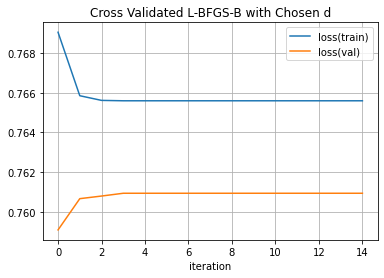

In [0]:
# Plot the loss histories

iters = range(0,n_iter)
plt.plot(iters,best_train_loss_history,label="loss(train)")
plt.plot(iters,best_val_loss_history,label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("Cross Validated L-BFGS-B with Chosen d")

#### Save the weights into Google Drive

Uncomment/modify this section to save the weights



In [0]:
# !ls '/content/drive/My Drive/DSA4212/Assignments/Assignment 2/'

'Book Recommendation Final.ipynb'   books_and_ratings.zip


In [0]:
# SAVE_DIRECTORY = "/content/drive/My Drive/DSA4212/Assignments/Assignment 2/"

In [0]:
# # Save the weights
# np.save(SAVE_DIRECTORY + "best_U.npy", best_U)
# np.save(SAVE_DIRECTORY + "best_B.npy", best_B)

In [0]:
# # Save the histories
# train_loss_history_npy = onp.asarray(train_loss_history)
# val_loss_history_npy = onp.asarray(val_loss_history)
# np.save(SAVE_DIRECTORY + "train_loss_history.npy", train_loss_history_npy)
# np.save(SAVE_DIRECTORY + "val_loss_history.npy", val_loss_history_npy)

#### Load the Saved Weights

Uncomment/modify this section to load the saved weights

In [0]:
# # Uncomment this if we are using the saved weights for testing
# SAVE_DIRECTORY = "/content/drive/My Drive/DSA4212/Assignments/Assignment 2/"

In [0]:
# # Uncomment this if we are using the saved weights for testing
# loaded_best_U = np.load(SAVE_DIRECTORY + "best_U.npy")
# loaded_best_B = np.load(SAVE_DIRECTORY + "best_B.npy")

In [0]:
# # Uncomment this if we are using the saved weights for testing
# best_U = loaded_best_U
# best_B = loaded_best_B

In [0]:
# # Uncomment this if we are using the saved histories for plotting
# loaded_train_loss_history = np.load(SAVE_DIRECTORY + "train_loss_history.npy")
# loaded_val_loss_history = np.load(SAVE_DIRECTORY + "val_loss_history.npy")
# train_loss_history = loaded_train_loss_history.tolist()
# val_loss_history = loaded_val_loss_history.tolist()

#### Test the Factor Model with L-BFGS-B

In [128]:
fact_test = r_test.copy()
naive_train = fact_train.copy()
display(naive_train.head(2))

,user_id,book_id,rating,mean_rating,r_ub
671645,1,10,4,3.694444,0.305556
671628,1,11,5,3.694444,1.305556


In [0]:
# Test Loss Function

def test_loss(test_df,naive_train_df,best_U,best_B):
  r_hat = best_U @ best_B.T # Shape of |U|x|B| of train set 

  naive_train_df2 = naive_train_df.drop('book_id',axis=1)
  naive_train_df3 = naive_train_df2.groupby('user_id').mean().reset_index()
  R_naive_npy = onp.array(naive_train_df3['mean_rating']) # Obtain the naive estimated rating for each user in the train set

  test_id_npy = onp.array(test_df[['user_id','book_id']]) # Obtain the user_id and book_id from the test set
  adj_user_ids = [x-1 for x in test_id_npy[:,0]] # adjust the user_id in test set for zero-based indexing
  adj_book_ids = [x-1 for x in test_id_npy[:,1]] # adjust the book_id in test set for zero-based indexing

  test_r_hat = r_hat[adj_user_ids,adj_book_ids] # extract the r_hats for the corresponding pairs of user_id and book_id  
  test_R_naive = R_naive_npy[adj_user_ids] # extract the R_naive for the corresponding user_id
  R_hat = test_R_naive + test_r_hat # Get the estimated rating for the corresponding pairs of user_id and book_id

  R_ub = onp.array(test_df['rating']) # Get the actual ratings from the test set

  return np.mean((R_ub - R_hat)**2) # Find the mean squared error

In [134]:
test_mse = test_loss(r_test,naive_train,best_U,best_B)
print("The Factor Model Test MSE is", test_mse)

The Factor Model Test MSE is 0.7980425518227283


In conclusion, of all the models, the factor model with d = 1 performed the best with the lowest loss or test MSE. The factor model does slightly better than the user mean model and we can see why. The factor model adjusts the `mean_rating` of each user to become closer to the actual rating that each user gave to each book by estimating and compensating for the residuals from the difference between the actual rating and the naive predicted rating.